In [1]:
from src.dataloaders.brats import BRATS
from src.dataloaders.elastic_trans import BRATS as BRATS_EL
from src.dataloaders.affine_trans import BRATS as BRATS_AFF
from src.models.unet import UNet
from src.utils import get_device, IoU as iou
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
lr = 0.0001
nr_epochs = 5
loss = "dice"
n_filters = 32

device = get_device()

model = UNet().to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_set = BRATS('../../../../special-course/data/BRATS_20_images', mode="train", subset=0.6, size=[64, 64, 155])
valid_set = BRATS('../../../../special-course/data/BRATS_20_images', mode='val', subset=0.6, size=[64, 64, 155])

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=False, drop_last=False)
print('train', len(train_set), len(train_dataloader))
print('val', len(valid_set), len(valid_dataloader))


Using mps
train 1860 1860
val 310 310


end of training for epoch4- loss 0.5734215909906197 -iou 1428.0290996377944
----------Epoch 0/5:loss-0.0
-epoch 0 index 2 batch 0
inp 476136.0 476136.0 False
target 3.0 3.0 True
pred4 -333273.62 -333273.62 False
pred5 0.010766381 0.010766381 False
matched_pixels 0 0 True


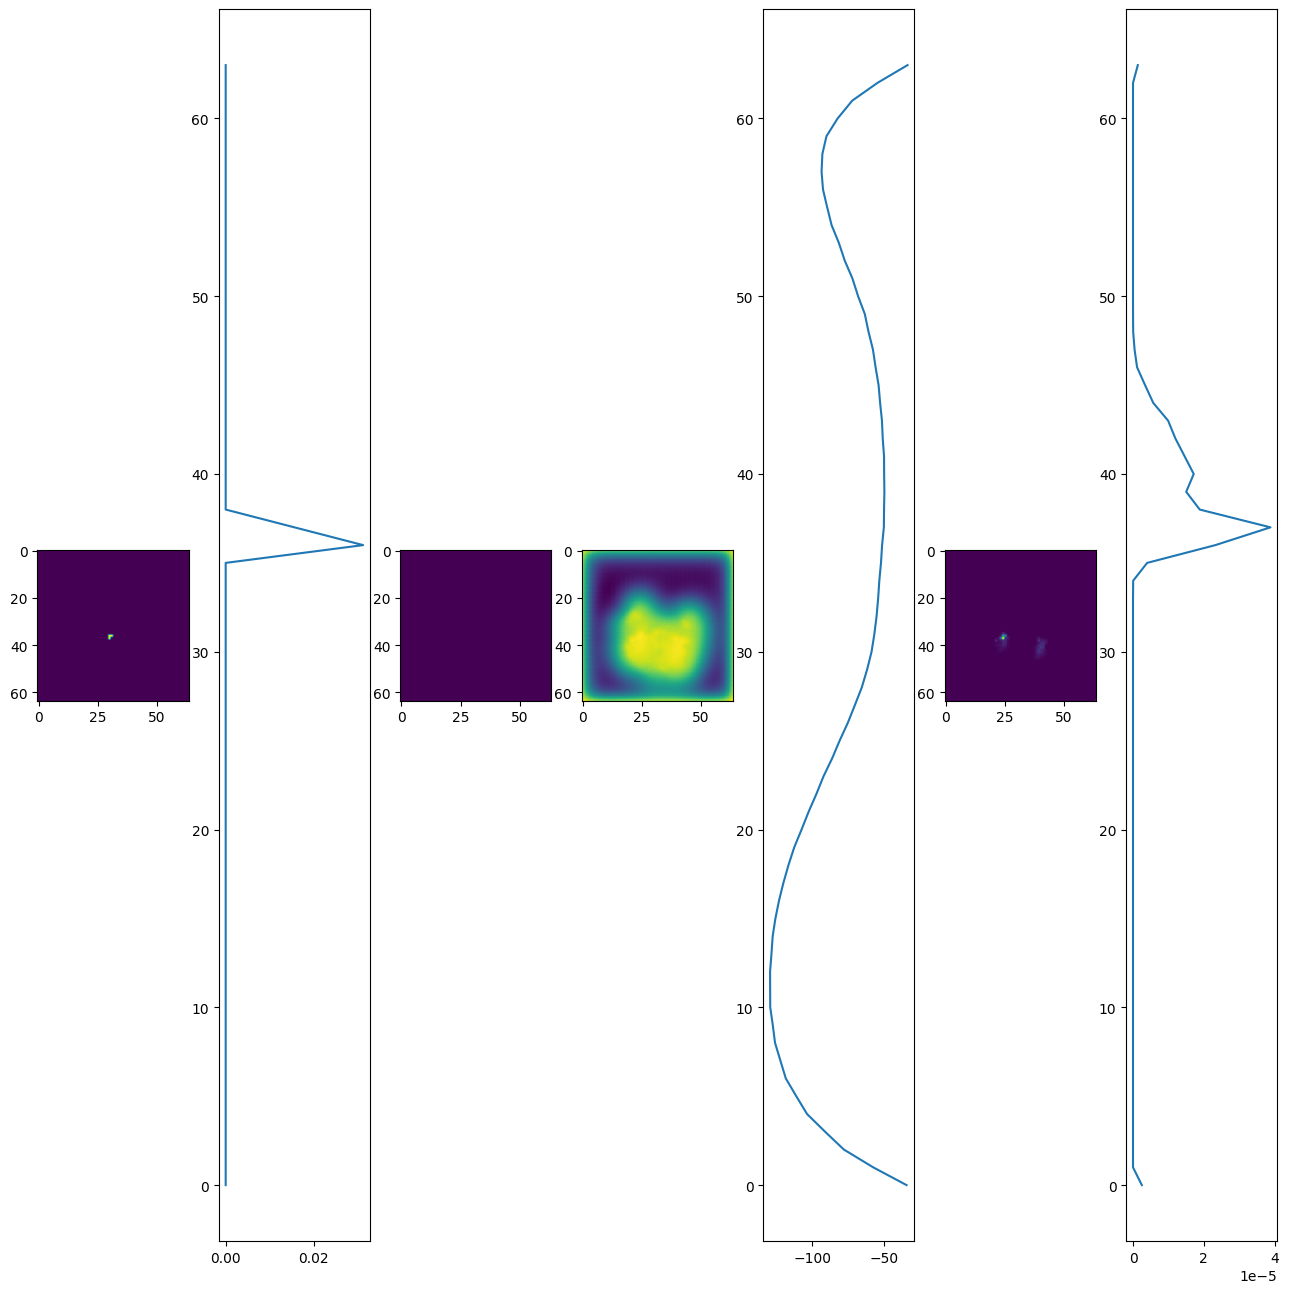

KeyboardInterrupt: 

In [7]:
for epoch in range(nr_epochs):
    epoch_loss = 0.0
    train_loss = 0.0
    train_iou = 0.0
    print(f'----------Epoch {epoch}/{nr_epochs}:loss-{epoch_loss}\n', end='')
    for index, (inputs, targets, _) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        optimizer.zero_grad()

        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.0115))
        loss = criterion(logits, targets)
        # loss = loss_function(logits, targets)
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
        train_iou += float(iou(targets.detach(), torch.sigmoid(logits.detach()).ge(0.5)))
        if index == 2:#and (not is_sweep):
            for i in range(0, len(inputs)):
                np_img = inputs.cpu().detach().numpy()
                np_target = targets.cpu().detach().numpy()
                np_pred4 = logits.detach().cpu().numpy()
                np_pred5 = torch.sigmoid(logits.detach()).cpu().detach().numpy()
                # np_pred6 = logits.cpu().numpy()
                # print('-epoch', epoch, 'index', index, 'loss for current index', loss.item(), 'loss', train_loss, 'iou', train_iou)
                print('-epoch', epoch, 'index', index, 'batch', i)
                # print('target1', np.sum(np_target), len(np.unique(np_target)) <= 2)
                # print(np_img.shape, np_target.shape, np_pred.shape)
                # if np_target.any():
                print('inp', np_img.sum(), np.sum(np_img),  len(np.unique(np_img)) <= 2)
                print('target', np_target.sum(), np.sum(np_target),  len(np.unique(np_target)) <= 2)
                print('pred4', np_pred4.sum(), np.sum(np_pred4),  len(np.unique(np_pred4)) <= 2)
                print('pred5', np_pred5.sum(), np.sum(np_pred5),  len(np.unique(np_pred5)) <= 2)
                    # print('pred6', np_pred6.sum(), np.sum(np_pred6),  len(np.unique(np_pred6)) <= 2)
                matched_pixels = np.where((np_target > 0) & (np_pred4 > 0.5), 1, 0)
                print('matched_pixels', matched_pixels.sum(), np.sum(matched_pixels),  len(np.unique(matched_pixels)) <= 2)
                fig, ax = plt.subplots(1, 7, figsize=(16,16))
                ax[0].imshow(np_target[0, 0, :, :])
                ax[1].plot(np_target[0, 0, :, :].mean(axis=1), range(len(np_target[0, 0, :, :])))
                ax[2].imshow(matched_pixels[0, 0, :, :])
                ax[3].imshow(np_pred4[0, 0, :, :])
                ax[4].plot(np_pred4[0, 0, :, :].mean(axis=1), range(len(np_pred4[0, 0, :, :])))
                ax[5].imshow(np_pred5[0, 0, :, :])
                ax[6].plot(np_pred5[0, 0, :, :].mean(axis=1), range(len(np_pred5[0, 0, :, :])))
                    # ax[7].imshow(np_pred6[0, 0, :, :])
                    # ax[8].plot(np_pred6[0, 0, :, :].mean(axis=1), range(len(np_pred6[0, 0, :, :])))

                    # ax[0][0].imshow(np_img[0, 0, :, :])
                    # ax[0][1].imshow(np_img[0, 1, :, :])
                    # ax[0][2].imshow(np_img[0, 2, :, :])
                    # ax[0][3].imshow(np_img[0, 3, :, :])
                    # ax[1][0].imshow(np_target[0, 0, :, :])
                    # ax[1][1].plot(np_target[0, 0, :, :].mean(axis=1), range(len(np_target[0, 0, :, :])))
                    # ax[1][2].imshow(matched_pixels[0, 0, :, :])
                    # ax[1][3].imshow(np_pred[0, 0, :, :])
                    # ax[1][3].plot(np_pred[0, 0, :, :].mean(axis=1), range(len(np_pred[0, 0, :, :])))
                plt.show()

    print(f'end of training for epoch{epoch}- loss {train_loss} -iou {train_iou}')
    # val_loss = 0
    # val_iou = 0
    # model.eval()
    # with torch.no_grad():
    #     test_loss = 0
    #     for index, (inputs, targets, _) in enumerate(valid_dataloader):
    #         val_inputs, val_targets = inputs.to(device), targets.to(device)
    #         val_logits = model(val_inputs)
    #         # loss = loss_function(val_logits, val_targets)
    #         # pos_weight = compute_pos_weight(targets)
    #         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.0115))
    #         loss = criterion(val_logits, val_targets)
    #         val_loss += loss.detach().item()
    #         val_loss += float(loss)
    #         val_iou += iou(val_targets.detach(), torch.sigmoid(val_logits.detach()).ge(0.5))
    #     print(f'----------end of validation for epoch{epoch}- loss {val_loss} -iou {val_iou}')

